In [125]:
import pandas as pd
import geopandas as gpd
import rasterio as rio

from sklearn.metrics import f1_score, accuracy_score

import sys
sys.path.append("..")
from src.datasets_labeled import labeled_datasets
from src.ETL.constants import LAT, LON, SUBSET, CROP_PROB

# Load Tigray maps

In [281]:
# Boundary path
b_path = "/Users/izvonkov/Downloads/eth_admbnda_adm1_csa_bofed_20201008.shp"

# Load Seth's map
p1 = "/Users/izvonkov/Desktop/drive-download-20211216T194323Z-002/tigray_JanSep_2020_0pt35t_nov17a_binaryyNt-001.tif"
p2 = "/Users/izvonkov/Desktop/drive-download-20211216T194323Z-002/tigray_JanSep_2020_0pt35t_nov17a_binaryySEt.tif"

# Load our map
p3 = "/Users/izvonkov/Desktop/Ethiopia_Tigray_2020_v1_final.tif"
p4 = "/Users/izvonkov/Desktop/Ethiopia_Tigray_2020_v2.tiff"

In [282]:
tif1 = rio.open(p1)
tif2 = rio.open(p2)
tif3 = rio.open(p3)
tif4 = rio.open(p4)

In [224]:
tif1.bounds

BoundingBox(left=36.29993248, bottom=13.24991073, right=40.00003018, top=15.00015845)

In [225]:
tif2.bounds

BoundingBox(left=38.59949065, bottom=12.24992317, right=40.00003018, top=13.24991073)

In [226]:
tif3.bounds

BoundingBox(left=36.44995113690529, bottom=12.249966203425023, right=40.00000330821756, top=14.895145389042609)

In [283]:
tif4.bounds

BoundingBox(left=36.44995113690529, bottom=12.249966203425023, right=40.00000330821756, top=14.895145389042609)

# Load labels

In [325]:
df = [d for d in labeled_datasets if d.dataset == "Ethiopia_Tigray_2020"][0].load_labels(allow_processing=False)
df.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,dataset,dest_tif,filename,feature_dir,save_path,already_exists
0,39.679153,14.767569,2020-04-21,2021-04-16,ceo-2020-Ethiopia-Tigray-(Set-1)-sample-data-2...,0.0,2,testing,Ethiopia,Ethiopia_Tigray_2020,ceo-2020-Ethiopia-Tigray-_Set-1_-sample-data-2...,lat=14.76756896_lon=39.67915251_date=2020-04-2...,../data/features,../data/features/lat=14.76756896_lon=39.679152...,True
1,39.469386,14.422460,2020-04-21,2021-04-16,ceo-2020-Ethiopia-Tigray-(Set-1)-sample-data-2...,0.0,1,validation,Ethiopia,Ethiopia_Tigray_2020,ceo-2020-Ethiopia-Tigray-_Set-1_-sample-data-2...,lat=14.42246023_lon=39.46938645_date=2020-04-2...,../data/features,../data/features/lat=14.42246023_lon=39.469386...,True
2,39.965847,14.152642,2020-04-21,2021-04-16,ceo-2020-Ethiopia-Tigray-(Set-1)-sample-data-2...,0.0,2,validation,Ethiopia,Ethiopia_Tigray_2020,ceo-2020-Ethiopia-Tigray-_Set-1_-sample-data-2...,lat=14.15264209_lon=39.96584746_date=2020-04-2...,../data/features,../data/features/lat=14.15264209_lon=39.965847...,True
3,39.463458,13.733266,2020-04-21,2021-04-16,ceo-2020-Ethiopia-Tigray-(Set-1)-sample-data-2...,0.0,2,validation,Ethiopia,Ethiopia_Tigray_2020,ceo-2020-Ethiopia-Tigray-_Set-1_-sample-data-2...,lat=13.7332662_lon=39.46345757_date=2020-04-21...,../data/features,../data/features/lat=13.7332662_lon=39.4634575...,True
4,39.328105,13.388338,2020-04-21,2021-04-16,ceo-2020-Ethiopia-Tigray-(Set-1)-sample-data-2...,1.0,2,testing,Ethiopia,Ethiopia_Tigray_2020,ceo-2020-Ethiopia-Tigray-_Set-1_-sample-data-2...,lat=13.38833826_lon=39.3281051_date=2020-04-21...,../data/features,../data/features/lat=13.38833826_lon=39.328105...,True


# Filter out points not inside map

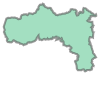

In [326]:
# Get shapefile
boundaries = gpd.read_file(b_path)
tigray_boundary = boundaries.iloc[0].geometry
tigray_boundary

In [327]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat))
gdf["in_map"] = gdf.geometry.apply(lambda x: tigray_boundary.contains(x))
gdf["in_map"].value_counts()

False    550
True     477
Name: in_map, dtype: int64

# Verify Predictions on validation set

In [351]:
# Points that weren't touched during training and testing
gdf_val = gdf[(gdf[SUBSET] == "validation")].copy()
len(gdf_val)

520

In [352]:
gdf_val[CROP_PROB].value_counts(normalize=True)

0.0    0.707692
1.0    0.292308
Name: crop_probability, dtype: float64

In [353]:
def print_accuracy_and_f1(actual, preds):
    print(f"F1-Score: {f1_score(actual, preds)}")
    print(f"Accuracy: {accuracy_score(actual, preds)}")

In [370]:
# Verify predictions on validation set:
# https://github.com/nasaharvest/crop-mask/blob/355a342a858eb69ce4bc1cdd81fcb75d91454ed9/data/model_metrics_validation.json#L53
actual_val = gdf_val[CROP_PROB]
preds = gdf_val.geometry.apply(lambda p: next(tif4.sample([(p.x, p.y)]))[0] > 0.5)
print_accuracy_and_f1(actual_val, preds)

F1-Score: 0.6568047337278107
Accuracy: 0.7769230769230769


# Predictions on Test Set

In [376]:
# Only in region and untouched during training/validation
gdf_test = gdf[gdf["in_map"] & (gdf[SUBSET] == "testing")]
actual_test = gdf_test[CROP_PROB]
actual_test.value_counts()

0.0    162
1.0     73
Name: crop_probability, dtype: int64

In [377]:
Seth_preds = gdf_test.geometry.apply(lambda p: next(tif1.sample([(p.x, p.y)]))[0] or next(tif2.sample([(p.x, p.y)]))[0])
print_accuracy_and_f1(actual_test, Seth_preds)

F1-Score: 0.6176470588235294
Accuracy: 0.7787234042553192


In [378]:
our_preds_v1 = gdf_test.geometry.apply(lambda p: next(tif3.sample([(p.x, p.y)]))[0] > 0.5)
print_accuracy_and_f1(actual_test, our_preds_v1)

F1-Score: 0.6124401913875598
Accuracy: 0.6553191489361702


In [379]:
our_preds_v2 = gdf_test.geometry.apply(lambda p: next(tif4.sample([(p.x, p.y)]))[0] > 0.5)
print_accuracy_and_f1(actual_test, our_preds_v2)

F1-Score: 0.576923076923077
Accuracy: 0.7191489361702128
